<a href="https://colab.research.google.com/github/maxmatical/TMLS_NLP/blob/master/twitter_sentiment_improvements_bwd_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%%capture
!pip install git+https://github.com/fastai/fastai.git

In [2]:
# Set up environment and download course-v3
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from fastai import *
from fastai.text import *
from fastai.utils.show_install import *
from fastai.callbacks import *
show_install()



```text
=== Software === 
python        : 3.6.8
fastai        : 1.0.60.dev0
fastprogress  : 0.1.21
torch         : 1.3.0+cu100
nvidia driver : 418.67
torch cuda    : 10.0.130 / is available
torch cudnn   : 7603 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 11441MB | Tesla K80

=== Environment === 
platform      : Linux-4.14.137+-x86_64-with-Ubuntu-18.04-bionic
distro        : #1 SMP Thu Aug 8 02:47:02 PDT 2019
conda env     : Unknown
python        : /usr/bin/python3
sys.path      : 
/env/python
/usr/lib/python36.zip
/usr/lib/python3.6
/usr/lib/python3.6/lib-dynload
/usr/local/lib/python3.6/dist-packages
/usr/lib/python3/dist-packages
/usr/local/lib/python3.6/dist-packages/IPython/extensions
/root/.ipython
```

Please make sure to include opening/closing ``` when you paste into forums/github to make the reports appear formatted as code sections.

Optional package(s) to enhance the diagnostics can be installed with:
pip install distro
Once installe

# EDA

In [0]:
df = pd.read_csv('testset1.csv')

In [5]:
print(len(df))

df.head(5)

5585


,id,name,date,text,location,sentiment
0,1.130000e+18,Evolutionomics,Sun May 19 23:57:10 +0000 2019,By combining short positions on #Gold $GOLD $G...,NaN,bearish
1,1.130000e+18,macrohedged,Sun May 19 23:55:02 +0000 2019,Here are the #Volatility levels for the majors...,England,unrelated
2,1.130000e+18,Evolutionomics,Sun May 19 23:54:06 +0000 2019,We have little insight into what will happen t...,NaN,neutral
3,1.130000e+18,Evolutionomics,Sun May 19 23:50:59 +0000 2019,"This brings us to #Gold miners. As a group, $G...",NaN,neutral
4,1.130000e+18,macrohedged,Sun May 19 23:50:04 +0000 2019,"Good morning Asia, here are the benchmark futu...",England,unrelated


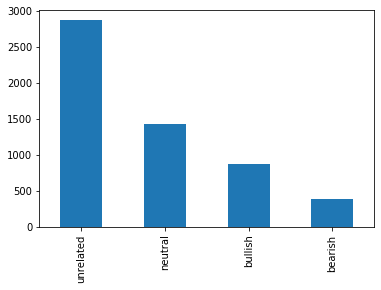

In [6]:
df['sentiment'].value_counts().plot(kind='bar')

Unrelated and neutral sentiments dominate the data currently (although this might not be the case in the future with the full dataset). It might be better to use a stratified sampling technique for classification

In [7]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
sss.get_n_splits(df['text'], df['sentiment'])

print(sss)



StratifiedShuffleSplit(n_splits=5, random_state=0, test_size=0.2,
            train_size=None)


In [8]:
train_idx, val_idx = next(sss.split(df['text'], df['sentiment']))

print(len(train_idx), len(val_idx))

4468 1117


Verifying that the stratified split preseves the distribution of the labels

In [0]:
df_train = df.iloc[train_idx, :]
df_val = df.iloc[val_idx, :]

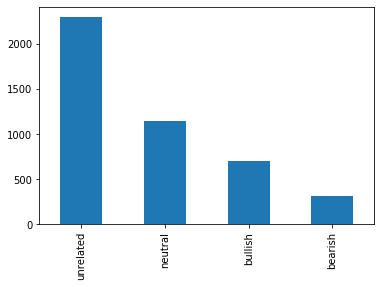

In [10]:
df_train['sentiment'].value_counts().plot(kind='bar')

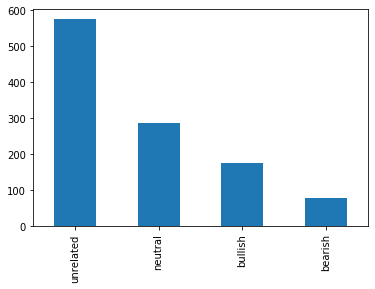

In [11]:
df_val['sentiment'].value_counts().plot(kind='bar')

Looks like the distribution of the labels in train and val are the same, so we can start modelling now

# Handling Imbalanced Data: Oversampling

In [0]:
df_class_bull = df_train[df_train['sentiment'] == 'bullish']
df_class_bear = df_train[df_train['sentiment'] == 'bearish']
df_class_neutral = df_train[df_train['sentiment'] == 'neutral']
df_class_unrelated = df_train[df_train['sentiment'] == 'unrelated']



In [13]:
print(len(df_class_unrelated))

2298


Want to oversample so that every class has 2298 counts

In [0]:
df_class_bull_over = df_class_bull.sample(len(df_class_unrelated), replace = True)
df_class_bear_over = df_class_bear.sample(len(df_class_unrelated), replace = True)
df_class_neutral_over = df_class_neutral.sample(len(df_class_unrelated), replace = True)


df_train_oversampled = pd.concat([df_class_bull_over, df_class_bear_over, df_class_neutral_over, df_class_unrelated], axis = 0)



Look at distribution of the labels in the oversampled data

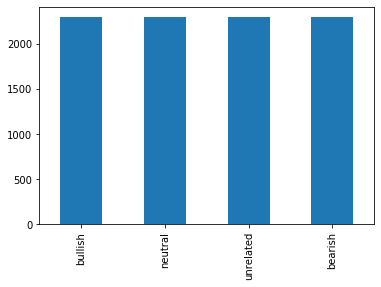

In [15]:
df_train_oversampled['sentiment'].value_counts().plot(kind='bar')

# Setting up data

In [0]:
PATH = '/content/'


In [17]:
ls{PATH}

data@  models@  testset1.csv


In [0]:
bs = 128

In [0]:

"""
Original databunch, no need for oversampling since were not doing classification
so we don't need to worry about class imbalance

"""
# data_lm = TextLMDataBunch.from_csv(path = PATH, 
#                                    csv_name = 'testset1.csv', 
#                                    text_cols='text',
#                                    valid_pct = 0.1,
#                                    min_freq = 3,
#                                    bs = bs) 

data_lm_bkwd = TextLMDataBunch.from_csv(path = PATH, 
                                   csv_name = 'testset1.csv', 
                                   text_cols='text',
                                   valid_pct = 0.1,
                                   min_freq = 3,
                                   backwards=True,
                                   bs = bs) 


# data_lm.save('data_lm')

data_lm_bkwd.save('data_lm_bkwd')

In [0]:
# data_clas = (TextList.from_csv(path = PATH,
#                                 csv_name = 'testset1.csv',
#                                 vocab = data_lm.train_ds.vocab,
#                                 cols = 'text')
#                                 .split_by_idx(val_idx)
#                                 .label_from_df(cols='sentiment')
#                                 .databunch(bs = bs))

# data_clas = TextClasDataBunch.from_df(path = PATH,
#                                         train_df = df_train_oversampled,
#                                         valid_df = df_val,
#                                         vocab = data_lm.train_ds.vocab,
#                                         text_cols = 'text',
#                                         label_cols = 'sentiment',
#                                         bs = bs)


data_clas_bkwd = TextClasDataBunch.from_df(path = PATH,
                                        train_df = df_train_oversampled,
                                        valid_df = df_val,
                                        vocab = data_lm_bkwd.train_ds.vocab,
                                        text_cols = 'text',
                                        label_cols = 'sentiment',
                                        backwards = True,
                                        bs = bs)

# data_clas.save('text_data_clas')

data_clas_bkwd.save('data_clas_bkwd')

# Training backwards model


## Language Model



In [0]:
data_lm_bkwd = load_data(PATH, 'data_lm_bkwd', bs = bs, backwards=True)

Look at what the preprocessed text looks like

In [23]:
data_lm_bkwd.show_batch()

idx,text
0,"xxup weekly xxmaj gold xxup # : gold xxup $ weekly xxmaj xxbos spy xxup $ tnx xxup $ uup xxup $ gld xxup $ forex # \n \n sent & & posted trade premium xxmaj new xxmaj xxbos xxunk / t.co / / : https oilb xxup $ gld xxup $ focus xxmaj in news xxmaj war xxmaj trade xxmaj , resistance xxmaj trend xxmaj 3-month at prices"
1,gld xxup $ slv xxup $ spy xxup $ \n \n xxunk / t.co / / : https > 1 part xxmaj - ? next xxmaj what xxmaj . 4 xxrep rotation xxmaj sector xxmaj global xxmaj vs u.s. xxup xxbos 👍 🐂 . 250k - 100 $ . back hair your blow will market bull next xxmaj . elastic - non fees tx bc early in price impossible
2,xxmaj high xxmaj \n % +10 : dbc xxup $ commodities xxmaj \n % +10 : efa xxup $ eafe xxup \n % +14 : iwm xxup $ caps xxmaj small xxmaj \n % +15 : spy xxup $ 500 s&&p xxup \n % +19 : vnq xxup $ reits \n % +19 : qqq xxup $ 100 nasdaq xxmaj \n % +19
3,"xxmaj # forex xxmaj # stocks xxmaj # trading xxmaj # when ahead xxmaj get xxmaj xxbos hhd0wf7fny / t.co / / : https ! one this on section comments the read to wait n't ca , charts the in notes xxmaj \n \n fractal market bear xxmaj - gold xxup $ \n market bear of end 2015 3d xxup - btc xxup $ \n chart 3d"
4,btc xxup $ ae xxup $ ctr xxup $ dgd xxup $ hsr xxup $ nano xxup $ bnb xxup $ ven xxup $ trx xxup $ blz xxup $ icx xxup $ qtum xxup $ bcc xxup $ xxunk xxup $ ada xxup $ xxunk xxup $ salt xxup $ tix xxup $ rcn xxup $ xxunk xxup $ xxunk xxup $ xxunk xxup $ slr xxup $ unb


In [0]:


"""
Default AdamW
"""


learn_bkwd = language_model_learner(data_lm_bkwd, 
                               arch=AWD_LSTM,
                               pretrained = True,
                               loss_func = FlattenedLoss(LabelSmoothingCrossEntropy, axis=-1),
                               drop_mult=1.).to_fp16()


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.00E-01
Min loss divided by 10: 5.25E-02


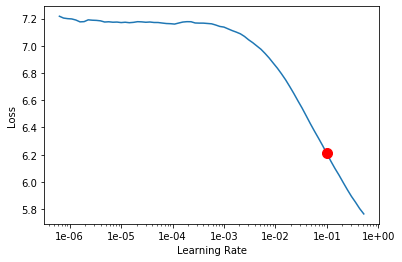

In [25]:
learn_bkwd.lr_find()
learn_bkwd.recorder.plot(suggestion = True, skip_end=15)

fitting learner

fit_fc for new optimizers

fit_one_cycle for adamw/lamb/LookaheadAdam

epoch,train_loss,valid_loss,accuracy,time
0,4.555593,3.100734,0.607924,00:30
1,3.489866,2.508145,0.744710,00:30
2,3.097463,2.495664,0.760759,00:30
3,2.929278,2.427113,0.772924,00:30
4,2.808628,2.376091,0.787478,00:30
5,2.702668,2.323559,0.796786,00:30
6,2.610370,2.265133,0.806406,00:30
7,2.529922,2.232135,0.814085,00:30
8,2.456218,2.212739,0.817187,00:30
9,2.407806,2.211560,0.817210,00:30


Better model found at epoch 0 with accuracy value: 0.6079241037368774.
Better model found at epoch 1 with accuracy value: 0.744709849357605.
Better model found at epoch 2 with accuracy value: 0.7607589364051819.
Better model found at epoch 3 with accuracy value: 0.7729240655899048.
Better model found at epoch 4 with accuracy value: 0.7874776721000671.
Better model found at epoch 5 with accuracy value: 0.7967857122421265.
Better model found at epoch 6 with accuracy value: 0.8064061999320984.
Better model found at epoch 7 with accuracy value: 0.8140848278999329.
Better model found at epoch 8 with accuracy value: 0.817187488079071.
Better model found at epoch 9 with accuracy value: 0.8172098398208618.


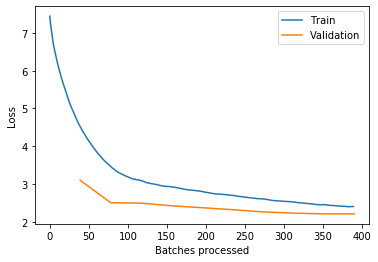

In [27]:
lr_init = 0.1

lr = lr_init

"""
1 cycle policy

"""

learn_bkwd.fit_one_cycle(10,
                   lr,
                   moms=(0.8,0.7),
                   callbacks=[SaveModelCallback(learn_bkwd, every='improvement', monitor='accuracy', 
                                                             name='lm_bkwd_stage1')])


"""
1 cycle policy without clipping momentum

"""

# learn.fit_one_cycle(5,
#                    lr,
#                    callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy', 
#                                                              name='lm_stage1'),])

learn_bkwd.recorder.plot_losses()

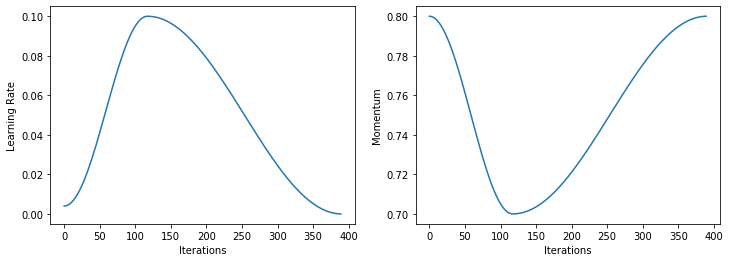

In [28]:
learn_bkwd.recorder.plot_lr(show_moms=True)

In [0]:
learn_bkwd.load('lm_bkwd_stage1');

learn_bkwd.unfreeze()


epoch,train_loss,valid_loss,accuracy,time
0,2.315748,2.155119,0.821005,00:41
1,2.252350,2.085813,0.829219,00:41
2,2.170489,2.045124,0.838862,00:41
3,2.108858,2.006443,0.845938,00:41
4,2.041487,1.979395,0.850714,00:41
5,1.976492,1.959842,0.855491,00:41
6,1.924071,1.942076,0.858705,00:41
7,1.883787,1.933844,0.860937,00:41
8,1.859683,1.933005,0.861741,00:41
9,1.841687,1.934455,0.861362,00:41


Better model found at epoch 0 with accuracy value: 0.8210045099258423.
Better model found at epoch 1 with accuracy value: 0.8292186856269836.
Better model found at epoch 2 with accuracy value: 0.8388615846633911.
Better model found at epoch 3 with accuracy value: 0.8459375500679016.
Better model found at epoch 4 with accuracy value: 0.8507143259048462.
Better model found at epoch 5 with accuracy value: 0.855491042137146.
Better model found at epoch 6 with accuracy value: 0.8587053418159485.
Better model found at epoch 7 with accuracy value: 0.8609374761581421.
Better model found at epoch 8 with accuracy value: 0.8617410659790039.


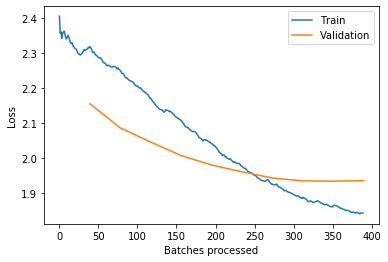

In [31]:
# train with smaller LR in last layer
lr = lr_init/10

learn_bkwd.fit_one_cycle(10,
                   slice(lr/(2.6**4),lr),
                   moms=(0.8,0.7),
                   callbacks=[SaveModelCallback(learn_bkwd, every='improvement', monitor='accuracy', 
                   name='lm_bkwd_stage2')])


learn_bkwd.recorder.plot_losses()



Testing the performance of our language model

In [0]:
learn_bkwd.load('lm_bkwd_stage2');

In [33]:
learn_bkwd.predict('$GLD is ', 20, temperature=0.25, min_p=0.001)

'$GLD is  debt our now . deal china To interest due , volatile so markets u.s. EMERGING if ’s'

Save encoder for classification

In [0]:
learn_bkwd.save_encoder('lm_bkwd_encoder')

## Classifier

In [0]:
data_clas_bkwd = load_data(PATH, 'data_clas_bkwd', bs = bs, backwards = True)

Look at the data

In [37]:
data_clas_bkwd.show_batch()

text,target
xxunk / t.co / / : https xxunk xxup $ xxunk xxup $ xxunk xxup $ exc xxup $ xxunk xxup $ xxunk xxup $ i $ xxunk xxup $ mac xxup $ xxunk xxup $ xxunk xxup $ xxunk xxup $ veev xxup $ xxunk xxup $ xxunk xxup $ gold xxup $ xxunk xxup $ xxunk xxup $ nvs xxup $ nee xxup $ xxunk xxup $ xxunk,unrelated
xlp xxup $ 🍞 % xxunk \n xlu xxup $ 🔌 % xxunk \n xxunk 🔻 \n \n qqq xxup $ ️ ♣ xxunk \n xlk xxup $ 💻 % 0.03 \n xli xxup $ 🏭 % 0.09 \n xxunk xxmaj # ️ ♂ ‍ 🤷 \n \n gld xxup $ 🏅 % 0.11 \n xly xxup $ 💍 % xxunk \n,neutral
xlp xxup $ 🍞 % xxunk \n xlu xxup $ 🔌 % xxunk \n xxunk 🔻 \n \n qqq xxup $ ️ ♣ xxunk \n xlk xxup $ 💻 % 0.03 \n xli xxup $ 🏭 % 0.09 \n xxunk xxmaj # ️ ♂ ‍ 🤷 \n \n gld xxup $ 🏅 % 0.11 \n xly xxup $ 💍 % xxunk \n,neutral
xlp xxup $ 🍞 % xxunk \n xlu xxup $ 🔌 % xxunk \n xxunk 🔻 \n \n qqq xxup $ ️ ♣ xxunk \n xlk xxup $ 💻 % 0.03 \n xli xxup $ 🏭 % 0.09 \n xxunk xxmaj # ️ ♂ ‍ 🤷 \n \n gld xxup $ 🏅 % 0.11 \n xly xxup $ 💍 % xxunk \n,neutral
xlp xxup $ 🍞 % xxunk \n xlu xxup $ 🔌 % xxunk \n xxunk 🔻 \n \n qqq xxup $ ️ ♣ xxunk \n xlk xxup $ 💻 % 0.03 \n xli xxup $ 🏭 % 0.09 \n xxunk xxmaj # ️ ♂ ‍ 🤷 \n \n gld xxup $ 🏅 % 0.11 \n xly xxup $ 💍 % xxunk \n,neutral


Making sure the vocab is the same between the language model and classifier

In [0]:
data_clas_bkwd.vocab.itos = data_lm_bkwd.vocab.itos

Training classifier layer

In [0]:


"""
learner with default adamw

"""
learn_bkwd = text_classifier_learner(data_clas_bkwd, 
                                arch = AWD_LSTM,
                                loss_func = FlattenedLoss(LabelSmoothingCrossEntropy, axis=-1),
                                drop_mult=0.1,
                                metrics = [accuracy]).to_fp16()

learn_bkwd.load_encoder('lm_bkwd_encoder')
learn_bkwd.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.20E-03
Min loss divided by 10: 2.09E-02


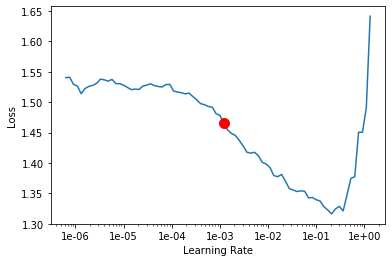

In [40]:
learn_bkwd.lr_find()
learn_bkwd.recorder.plot(suggestion = True)

epoch,train_loss,valid_loss,accuracy,time
0,1.289790,1.259888,0.563115,00:29
1,1.179943,0.970793,0.658013,00:27
2,1.126308,0.891023,0.751119,00:25
3,1.070380,1.096602,0.675022,00:25
4,1.022669,0.921453,0.717995,00:27
5,1.050411,1.329203,0.625783,00:26
6,1.029264,0.884083,0.739481,00:27
7,1.054365,0.867603,0.791406,00:25
8,0.909884,0.768127,0.794091,00:26
9,0.813252,0.788577,0.779767,00:28


Better model found at epoch 0 with accuracy value: 0.5631154775619507.
Better model found at epoch 1 with accuracy value: 0.6580125093460083.
Better model found at epoch 2 with accuracy value: 0.751119077205658.
Better model found at epoch 7 with accuracy value: 0.7914055585861206.
Better model found at epoch 8 with accuracy value: 0.7940913438796997.


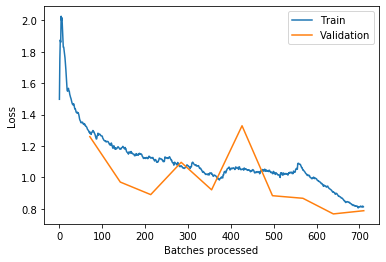

In [41]:
lr_init = 0.1
lr = lr_init

# learn.fit_one_cycle(10, 
#                    lr, 
#                    moms=(0.8,0.7),
#                    callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy', 
#                                                              name='classifier_stage1')])
learn_bkwd.fit_fc(10,
             lr,
             moms=(0.8,0.7),
             callbacks=[SaveModelCallback(learn_bkwd, every='improvement', monitor='accuracy', 
             name='classifier_bkwd_stage1')])


learn_bkwd.recorder.plot_losses()

Gradual unfreezing



In [0]:
learn_bkwd.load('classifier_bkwd_stage1');
learn_bkwd.freeze_to(-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.857744,0.949413,0.735900,00:27
1,1.083929,0.993261,0.698299,00:24
2,0.926361,0.773851,0.783348,00:26
3,0.863869,0.774484,0.787825,00:28
4,0.796446,0.773674,0.803939,00:28


Better model found at epoch 0 with accuracy value: 0.7358997464179993.
Better model found at epoch 2 with accuracy value: 0.7833482623100281.
Better model found at epoch 3 with accuracy value: 0.7878245115280151.
Better model found at epoch 4 with accuracy value: 0.8039391040802002.


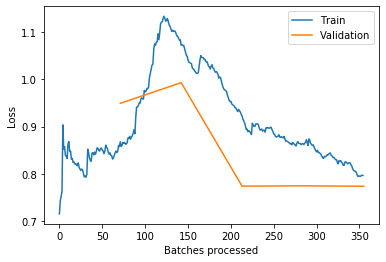

In [43]:
lr = lr_init

learn_bkwd.fit_one_cycle(5,
                   slice(lr/(2.6**4),lr), 
                   moms=(0.8,0.7),
                   callbacks=[SaveModelCallback(learn_bkwd, every='improvement', monitor='accuracy', 
                                                             name='classifier_bkwd_stage2')])

learn_bkwd.recorder.plot_losses()

In [0]:
learn_bkwd.load('classifier_bkwd_stage2');
learn_bkwd.freeze_to(-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.957270,0.822017,0.770815,00:36
1,0.918718,0.787392,0.790510,00:33
2,0.784185,0.728675,0.834378,00:31
3,0.642429,0.698301,0.854073,00:31
4,0.552814,0.698857,0.851388,00:29


Better model found at epoch 0 with accuracy value: 0.7708146572113037.
Better model found at epoch 1 with accuracy value: 0.7905102968215942.
Better model found at epoch 2 with accuracy value: 0.8343778252601624.
Better model found at epoch 3 with accuracy value: 0.8540734052658081.


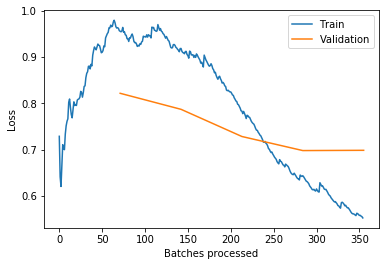

In [48]:
# divide lr in last layer (/2)

lr=lr_init/2

learn_bkwd.fit_one_cycle(5,
                   slice(lr/(2.6**4),lr), 
                   moms=(0.8,0.7),
                   callbacks=[SaveModelCallback(learn_bkwd, every='improvement', monitor='accuracy', 
                                                             name='classifier_bkwd_stage3')])

learn_bkwd.recorder.plot_losses()

In [0]:
learn_bkwd.load('classifier_bkwd_stage3');
learn_bkwd.unfreeze()

epoch,train_loss,valid_loss,accuracy,time
0,0.529559,0.708241,0.849597,01:11
1,0.531911,0.702030,0.844226,01:17
2,0.544341,0.734181,0.851388,01:21
3,0.526907,0.682158,0.863026,01:12
4,0.516190,0.664731,0.858550,01:08
5,0.500633,0.664756,0.868397,01:12
6,0.465113,0.643727,0.868397,01:11
7,0.442286,0.635920,0.867502,01:21
8,0.458749,0.643102,0.867502,01:12
9,0.460221,0.648524,0.865712,01:19


Better model found at epoch 0 with accuracy value: 0.849597156047821.
Better model found at epoch 2 with accuracy value: 0.851387619972229.
Better model found at epoch 3 with accuracy value: 0.863025963306427.
Better model found at epoch 5 with accuracy value: 0.8683974742889404.


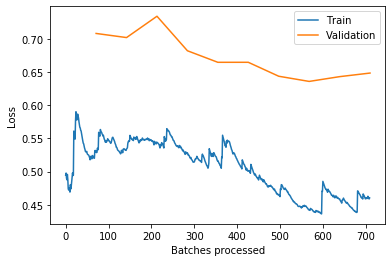

In [50]:
# decrease lr in last layer (/10)

lr = lr_init/10

learn_bkwd.fit_one_cycle(10,
                   slice(lr/(2.6**4),lr), 
                   moms=(0.8,0.7),
                   callbacks=[SaveModelCallback(learn_bkwd, every='improvement', monitor='accuracy', 
                                                             name='classifier_bkwd_final')])

learn_bkwd.recorder.plot_losses()

Optional additional training

In [0]:
# learn.load('radam_classifier_final');


# learn.fit_one_cycle(10,
#                    slice(lr/(2.6**4),lr), 
#                    moms=(0.8,0.7),
#                    callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy', 
#                                                              name='radam_classifier_final_2')])

# learn.recorder.plot_losses()

Additional training doesn't seem to benefit 

final accuracy approximately 0.86571

Exporting model

In [0]:
learn_bkwd.load('classifier_bkwd_final');

learn_bkwd.export()